# AIM

See About.txt

### 1. Part 1

In [1]:
import sys 
sys.path.append('C:\\Users\\Eesh Gupta\\Documents\\RU Research\\Chakram')
sys.path.append('C:\\Users\\Eesh Gupta\\Documents\\RU Research\\Chakram\\ECD_control')


In [2]:
from ECD_control import ECD_optimization
from ECD_control import ECD_pulse_construction

import numpy as np
import qutip as qt 
from ECD_control.ECD_optimization.batch_optimizer import BatchOptimizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Need tf version 2.3.0 or later. Using tensorflow version: 2.7.0


Need tf version 2.3.0 or later. Using tensorflow version: 2.7.0



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12751846439082514720
 xla_global_id: -1]

### 2. Part 2

##### Getting the Drive

In [3]:
from ECD_control import ECD_optimization
from ECD_control import ECD_pulse_construction

import numpy as np
import qutip as qt 
from ECD_control.ECD_optimization.batch_optimizer import BatchOptimizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *

In [5]:
# Import Data 
import numpy as np
fname = 'Test_00_10_May23.txt'
b_file = open(fname, "r")
params = np.loadtxt(b_file)
print(params)

[[-1.39062333 -1.5805974  -2.60015082 -0.57049859]
 [-3.3814621   1.74659038  0.69830352 -1.70698524]
 [-0.5962196   0.33704624  0.21858694 -0.04420422]
 [-1.88043606  0.7057426   0.15740366 -0.97481567]
 [ 0.         -2.37121439  1.32579303  1.89272666]
 [ 0.00841689  3.13234544 -3.14032674  0.0129838 ]
 [ 1.57079625  1.57079625  1.57079625  1.57079625]]


In [6]:
import cmath
betas = np.asarray([complex(params[0][i], params[1][i]) for i in range(len(params[0]))])
phis = params[4]
thetas = params[5]

#the parameters in our circuit. Can be user defined, or loaded from the result of an ECD optimization.

print('betas:' + str(betas))
print('phis:' + str(phis))
print('thetas:' + str(thetas))

betas:[-1.39062333-3.3814621j  -1.5805974 +1.74659038j -2.60015082+0.69830352j
 -0.57049859-1.70698524j]
phis:[ 0.         -2.37121439  1.32579303  1.89272666]
thetas:[ 0.00841689  3.13234544 -3.14032674  0.0129838 ]


In [7]:
#Our cavity and qubit. When using pulse construction on the FPGA, these objects can be loaded, and 
#Here, we are making a "FakeCavity" and a "FakeQubit" with parameters found from experimental calibrations.

storage_params = {
        "chi_kHz": -33, #dispersive shift
        "chi_prime_Hz": 0, #second order dispersive shift
        "Ks_Hz": 0, #Kerr correction not yet implemented.
        "epsilon_m_MHz": 400, #largest oscillator drive amplitude in MHz (max|epsilon|)
        "unit_amp": 0.01, #DAC unit amp of gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement sigma
        "chop": 4, #oscillator displacement chop (number of stds. to include in gaussian pulse)
    }
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.

#calculating conversion between qubit DAC units and MHz (Omega)
pi = rotate(np.pi, phi=0, sigma=qubit_params['sigma'], chop=qubit_params['chop'], dt=1)
Omega_m = np.real(np.max(pi))/qubit_params['unit_amp']

#creating the "Fake storage" and "Fake qubit"
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD = 30
#Small delay to insert between oscillator and qubit pulses
buffer_time = 4

In [8]:
#From these calibrations, the storage and qubit objects calculate the
#conversion between DAC amplitude, and drive amplitude in MHz.
#so, [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz 
#and [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz.
#These parameters also represent the maximum drive amplitude,
#since the DAC max amplitude is 1 (assuming amplifiers don't saturate.)
print('Maximum oscillator drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage.epsilon_m_MHz)
print('Maximum qubit drive amplitude: |Omega|/2*pi < %.3f MHz' % qubit.Omega_m_MHz)


Maximum oscillator drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum qubit drive amplitude: |Omega|/2*pi < 40.468 MHz


In [9]:
#generating the conditional displacement circuit.
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a displacement
pulse_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)
cavity_dac_pulse, qubit_dac_pulse, = pulse_dict['cavity_dac_pulse'], pulse_dict['qubit_dac_pulse']



C:\Users\Eesh Gupta\anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
cavity_dac_pulse_GHz = (2*np.pi)*(10**(-3))*storage.epsilon_m_MHz*cavity_dac_pulse #convert from DAC to Mhz to Ghz
qubit_dac_pulse_GHz = (2*np.pi)*10**(-3)*qubit.Omega_m_MHz*qubit_dac_pulse #convert from DAC to Mhz to Ghz

Text(0, 0.5, 'Ghz')

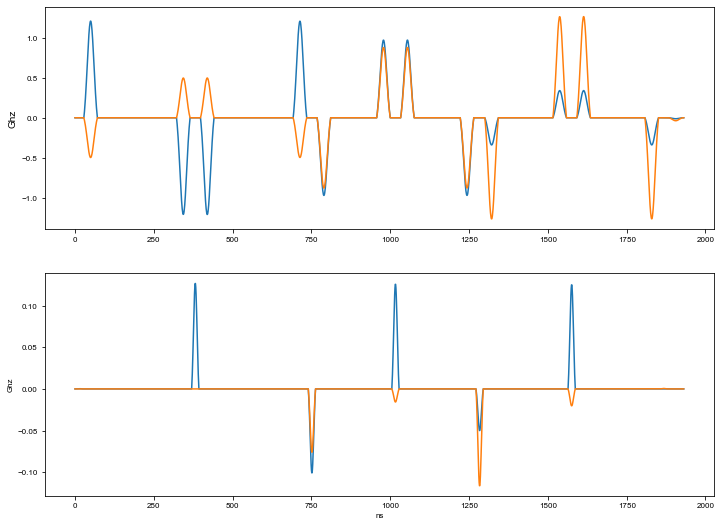

In [11]:
#plotting the pulse in GHz
fig, axs = plt.subplots(2,1)
axs[0].plot(np.real(cavity_dac_pulse_GHz))
axs[0].plot(np.imag(cavity_dac_pulse_GHz))
axs[0].set_ylabel('Ghz', fontsize = 10)
axs[1].plot(np.real(qubit_dac_pulse_GHz))
axs[1].plot(np.imag(qubit_dac_pulse_GHz))
plt.xlabel('ns')
plt.ylabel('Ghz')

##### Finding alpha(t)

In [12]:
def alpha_from_epsilon_nonlinear_finite_difference(
    epsilon_array, delta=0, alpha_init=0 + 0j):
    dt = 1
    alpha = np.zeros_like(epsilon_array)
    alpha[0] = alpha_init
    alpha[1] = alpha_init
    for j in range(1, len(epsilon_array) - 1):
        alpha[j + 1] = (
                2*
                 dt
                * (
                    -1j * delta# * alpha[j]
                    #- 2j * Ks * np.abs(alpha[j]) ** 2 * alpha[j]
                    #- (kappa / 2.0) * alpha[j]
                    - 1j * epsilon_array[j]
                )
                + alpha[j - 1])
    return alpha

In [14]:
alpha = alpha_from_epsilon_nonlinear_finite_difference(
    epsilon_array =cavity_dac_pulse_GHz , delta=0, alpha_init=0 + 0j)
alpha_star = np.conjugate(alpha)

Text(0.5, 0, 'ns')

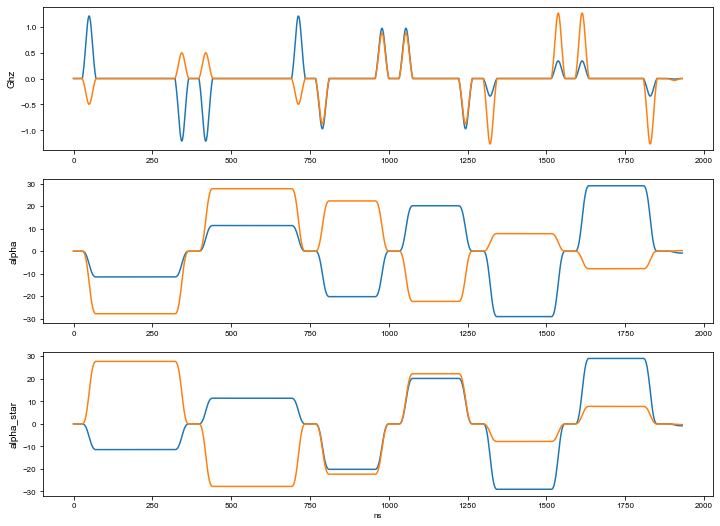

In [15]:
fig, axs = plt.subplots(3,1)
axs[0].plot(np.real(cavity_dac_pulse_GHz))
axs[0].plot(np.imag(cavity_dac_pulse_GHz))
axs[0].set_ylabel('Ghz', fontsize = 10)
axs[1].plot(np.real(alpha))
axs[1].plot(np.imag(alpha))
axs[1].set_ylabel('alpha', fontsize = 10)

axs[2].plot(np.real(alpha_star))
axs[2].plot(np.imag(alpha_star))
axs[2].set_ylabel('alpha_star', fontsize = 10)
plt.xlabel('ns')

##### Qutip Simulation

In [16]:
from qutip import *
from qutip.control import *
from math import *

In [17]:
T = len(cavity_dac_pulse)
times = np.linspace(0, T, T) #1ns timesteps

###### Qutip: System Hammy

In [35]:
n_c = 5  #number of levels in cavity
n_q = 2 #number of levels in qubit

#N = 1 #target cavity state

omega_c  = 5.26 *2*pi   #frequencies in GHz
omega_q = 6.65*2*pi
#K = -3.7*(10**(-6))*2*pi #cavity nonlinearity

#photon depenedent number shifts
chi = storage_params["chi_kHz"]*2*pi*(10**(-6)) #linear
chi_ = storage_params["chi_prime_Hz"]*(10**(-9)) #quadratic

##mode to mode coupling 
eta = 10**(-9)

In [36]:
# Creating identity, annhilitation/creation, num operators 
identity_q = qeye(n_q)
identity_c = qeye(n_c)

a_q = destroy(n_q)
a_c = destroy(n_c)

adag_q = create(n_q)
adag_c = create(n_c)

num_q = num(n_q)
num_c =  num(n_c)


c_ops = []

tlist = times




In [37]:
# Displace Frame hammy
H0_disp = ((chi/2)*tensor(sigmaz(), num_c, identity_c) # first mode -qubit
            +
          (chi/2)*tensor(sigmaz(), identity_c, num_c) # 2nd mode - qubit
           +
          (eta)*tensor(identity_q, num_c, num_c)) # MODE-MODE

In [45]:
def time_evo(pulses): 
    '''
    Given pulses, time evolves and returns fidelity
    
    '''
    qubit_pulse_GHz, alpha = pulses
    # prepping time depedent hammys

    H = [H0_disp,
         #Qubit drive
        [tensor(a_q, identity_c, identity_c), np.conjugate(qubit_pulse_GHz)], 
         [tensor(adag_q, identity_c, identity_c), qubit_pulse_GHz],

         # Desired Displacement term from qubit-mode coupling
         [(chi/2)*tensor(sigmaz(), a_c, identity_c), np.conjugate(alpha)],  
         [(chi/2)*tensor(sigmaz(), adag_c, identity_c), alpha]]
    
    #time evolution
    T = len(alpha)
    times = np.linspace(0, T, T)
    psi0 = tensor(basis(n_q,0), basis(n_c,0), basis(n_c,0))
    opts = Options(store_states=True, store_final_state=True, nsteps = 5000)
    output = mesolve(H, psi0 , times, c_ops, [], options =opts)
    
    target_state1 = tensor(basis(n_q,0), basis(n_c, 1), basis(n_c, 0))
    target_state2 = tensor(basis(n_q,1), basis(n_c, 1), basis(n_c, 0))
    rho = output.states[-1]
    fid1 = rho.overlap(target_state1)
    fid2 = rho.overlap(target_state2)
    
    return output, np.sqrt(fid1.real**2 + fid1.imag**2) , np.sqrt(fid2.real**2 + fid2.imag**2)
    
    

###### Qutip: Simulation

In [46]:
out, fid1, fid2 = time_evo([qubit_dac_pulse_GHz,alpha ])

In [47]:
fid1

0.0018339071438382894

In [48]:
fid2

0.18166083571374905

# Visualization

In [49]:
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plot.rcParams.update(params)

In [50]:
def plot_populations(output, figname):
    '''
    Given output of mesolve, outputs populations with qubit as ground
    '''
    fig = plt.figure(figsize=(10,8))
    probs = []
    times = [k for k in range(len(output.states))]
    max_num_levels = 2 # to be shown on the plot
    
    #qubit grounded
    for i in range(max_num_levels):
        for j in range(max_num_levels):
            target = tensor(basis(n_q,0), basis(n_c, i), basis(n_c, j))
            pops = []
            for k in range(len(output.states)): 
                z = target.overlap(output.states[k])
                pops.append(z.real**2 + z.imag**2)
            plt.plot(times, pops, label = '|g,'+str(i)+',' + str(j)+'>')
    
    #qubit excited
    for i in range(max_num_levels):
        for j in range(max_num_levels):
            target = tensor(basis(n_q,1), basis(n_c, i), basis(n_c, j))
            pops = []
            for k in range(len(output.states)): 
                z = target.overlap(output.states[k])
                pops.append(z.real**2 + z.imag**2)
            plt.plot(times, pops, label = '|e,'+str(i)+',' + str(j)+'>')
            
    plt.xlabel("Time (ns)", fontsize = 14)
    plt.ylabel("Populations", fontsize = 14)
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
#     plt.legend(prop={'size': 20},  fontsize = 8, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)   
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend()
    fig.savefig(figname, dpi = 1000)

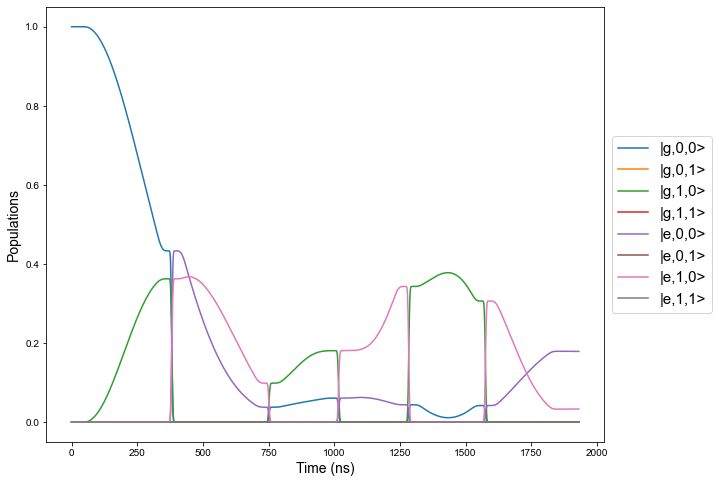

In [51]:
plot_populations(out, 'g00 to g01_eta1Hz.png')